# 検証1: フローの途中にユーザへの質問を挟むことができるか
https://github.com/langchain-ai/langgraph/blob/main/docs/docs/how-tos/human_in_the_loop/wait-user-input.ipynb

AskHuman called


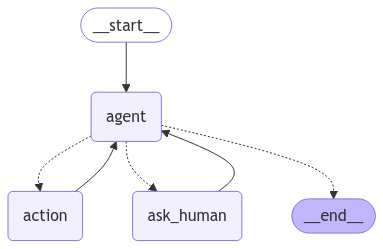

In [18]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, START
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel
from langgraph.checkpoint.memory import MemorySaver
from datetime import datetime, timedelta
from typing import Annotated, Literal, List, Optional, Dict
import random

@tool
def fetch_reviews(
    store_id: int,
    query: str,
    posted_at_from: datetime,
    posted_at_to: datetime,
    limit: int,
    sentiment: Literal["positive", "negative"],
    categories: Optional[List[str]] = [],
) -> List[dict]:
    """
    Fetch reviews from the JSON file based on the provided arguments.

    Args:
        store_id (int): The store ID.
        query (str): The search query.
        posted_at_from (datetime): The start of the date range.
        posted_at_to (datetime): The end of the date range.
        categories (list, optional): List of categories to filter by. Defaults to None.
        limit (int): Maximum number of reviews to fetch.
        sentiment (Literal['positive', 'negative']): Filter reviews by sentiment.

    Returns:
        list: A list of filtered review objects.
    """
    print('fetch_reviews called')

    mock_reviews = []
    if not categories:
        categories = ["雰囲気", "接客"]

    for i in range(limit):
        review_categories = random.sample(categories, k=min(len(categories), random.randint(1, 3)))
        review = {
            "store_id": store_id,
            "id": i + 1,
            "content": f"Mock review content for query '{query}' and category '{random.choice(categories)}'",
            "sentiment": sentiment,
            "categories": review_categories,
            "posted_at": (
                posted_at_from
                + timedelta(
                    days=random.randint(0, (posted_at_to - posted_at_from).days)
                )
            ).isoformat(),
        }
        mock_reviews.append(review)

    return mock_reviews

@tool
def fetch_categories() -> List[str]:
    """
    Fetch a list of predefined categories.

    Returns:
        list: A list of category strings.
    """
    print('fetch_categories called')

    return ["価格", "雰囲気", "接客", "品質"]

@tool
def fetch_store_ratings() -> Dict[int, float]:
    """
    Fetch store ratings for all stores.

    Returns:
        dict: A dictionary where keys are store IDs and values are ratings (1.0 to 5.0).
    """
    print('fetch_store_ratings called')

    return {
        1: 1.3,
        2: 4.0,
        3: 1.0,
        4: 3.5,
        5: 3.6,
        6: 3.9,
        7: 3.5,
        8: 4.9,
        9: 3.4,
        10: 2.0,
    }

@tool
def fetch_sales_trends(store_id: int) -> Dict[str, int]:
    """
    Fetch monthly sales trends for a specific store.

    Args:
        store_id (int): The store ID.

    Returns:
        dict: A dictionary where keys are months and values are sales numbers.
    """
    print('fetch_sales_trends called')

    sales_trends = {}
    for month in range(1, 13):
        if month in [7, 8]:
            sales = random.randint(2000, 3000)  # 7~8月の売り上げが高い
        else:
            sales = random.randint(500, 1500)
        sales_trends[f"2024-{month:02d}"] = sales
    sales_trends["2025-01"] = random.randint(500, 1500)
    return sales_trends


tools = [fetch_reviews, fetch_categories, fetch_store_ratings, fetch_sales_trends]
tool_node = ToolNode(tools)


model = ChatOpenAI(model="gpt-4o-mini", temperature=0)


class AskHuman(BaseModel):
    """Ask the human a question"""
    print('AskHuman called')

    question: str


model = model.bind_tools(tools + [AskHuman])

def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    else:
        return "action"


def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}


def ask_human(state):
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
    location = interrupt("Please provide your location:")
    tool_message = [{"tool_call_id": tool_call_id, "type": "tool", "content": location}]
    return {"messages": tool_message}

workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
)

workflow.add_edge("action", "agent")
workflow.add_edge("ask_human", "agent")

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png()))


In [20]:
user_input = "\n".join([
    "評価の低い店舗と売り上げを調べ、その店舗名をユーザーに伝えて、何が知りたいか質問してください",
    "知りたいことに合わせて口コミを絞り込み、ユーザーの知りたい内容を回答してください。"
])
config = {"configurable": {"thread_id": "2"}}
for event in app.stream(
    {
        "messages": [
            (
                "user",
                user_input,
            )
        ]
    },
    config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

評価の低い店舗と売り上げを調べ、その店舗名をユーザーに伝えて、何が知りたいか質問してください
知りたいことに合わせて口コミを絞り込み、ユーザーの知りたい内容を回答してください。
================================== Ai Message ==================================
Tool Calls:
  fetch_store_ratings (call_LHmouJSKhvrL8k2TdcRvxpp0)
 Call ID: call_LHmouJSKhvrL8k2TdcRvxpp0
  Args:
fetch_store_ratings called
================================= Tool Message =================================
Name: fetch_store_ratings

{"1": 1.3, "2": 4.0, "3": 1.0, "4": 3.5, "5": 3.6, "6": 3.9, "7": 3.5, "8": 4.9, "9": 3.4, "10": 2.0}
================================== Ai Message ==================================
Tool Calls:
  fetch_sales_trends (call_OrobMeWSRSRrSYjHOOnPS1A8)
 Call ID: call_OrobMeWSRSRrSYjHOOnPS1A8
  Args:
    store_id: 3
  fetch_sales_trends (call_PdFpo950DeiSDbOlfaHcD4EB)
 Call ID: call_PdFpo950DeiSDbOlfaHcD4EB
  Args:
    store_id: 1
  fetch_sales_trends (call_EedEMIua8yxxbu301D89h0o2)
 Call ID: call_Ee

In [21]:
for event in app.stream(Command(resume="直近一年で売り上げが良かった時期の口コミの特徴"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  AskHuman (call_3KXKPrFzU0tfM2adjW3zx1x1)
 Call ID: call_3KXKPrFzU0tfM2adjW3zx1x1
  Args:
    question: 評価の低い店舗は以下の通りです。

1. 店舗ID: 3 (評価: 1.0) - 売上トレンド: 2024年8月に2982、2024年9月に775、2024年10月に720
2. 店舗ID: 1 (評価: 1.3) - 売上トレンド: 2024年8月に2324、2024年9月に1366、2024年10月に644
3. 店舗ID: 10 (評価: 2.0) - 売上トレンド: 2024年8月に2158、2024年9月に999、2024年10月に1395

これらの店舗について、何が知りたいですか？（例: 口コミ、特定の問題、改善点など）
================================= Tool Message =================================

直近一年で売り上げが良かった時期の口コミの特徴
================================== Ai Message ==================================
Tool Calls:
  fetch_reviews (call_Thmh7kUYz71kedlF3qbRAeQv)
 Call ID: call_Thmh7kUYz71kedlF3qbRAeQv
  Args:
    store_id: 3
    query: 
    posted_at_from: 2024-08-01T00:00:00
    posted_at_to: 2024-08-31T23:59:59
    limit: 5
    sentiment: positive
  fetch_reviews (call_Jb9j7rVAxYYUtqoGlyICpfTB)
 Call ID: call_Jb9j7rVAxYYUtqoGlyICpfTB
  Arg